# Solution

In [1]:
# !pip install igraph
!pip install python-igraph==0.9.6
!pip install pipwin
!pipwin install cairocffi

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install numpy
# !pip install pandas

In [2]:
from igraph import *
import json
import random
import numpy as np
from numpy import linalg 
import itertools
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay  # needed for triangulation
import os
import pandas as pd
from copy import deepcopy

In [3]:
random.seed(2022)
np.random.seed(2022)

In [4]:
# file_geo = "/content/drive/MyDrive/los_angeles_censustracts.json"
# file_time = "/content/drive/MyDrive/los_angeles-censustracts-2019-4-All-MonthlyAggregate.csv"
file_geo = "los_angeles_censustracts.json"
file_time = "los_angeles-censustracts-2019-4-All-MonthlyAggregate.csv"

with open(file_geo) as f:
    census_tracts = json.loads(f.readline())

In [5]:
census_tracts['features'][0]['properties']

{'MOVEMENT_ID': '1', 'TRACT': '480302', 'DISPLAY_NAME': 'Census Tract 480302'}

In [6]:
np.array(census_tracts['features'][0]['geometry']['coordinates'][0]).mean(axis=0)  # [longitude, latitude]

array([-118.12053321,   34.10309557])

In [7]:
display_names = dict()
coordinates = dict()

for area in census_tracts['features']:
    id = int(area['properties']['MOVEMENT_ID'])
    display_name = area['properties']['DISPLAY_NAME']
    display_names[id] = display_name
    a = area['geometry']['coordinates'][0]
    coordinates[id] = np.array(a if type(a[0][0]) == float else a[0]).mean(axis=0)

In [8]:
for i in range(5):
    key = i + 1
    print('{}: {}, {}'.format(key, display_names[key], coordinates[key]))

1: Census Tract 480302, [-118.12053321   34.10309557]
2: Census Tract 480303, [-118.13785063   34.09645121]
3: Census Tract 480304, [-118.13138209   34.09626386]
4: Census Tract 480400, [-118.13224544   34.10349303]
5: Census Tract 480500, [-118.14492317   34.0986815 ]


In [9]:
g = Graph(directed=False)
g.add_vertices(len(display_names))
g.vs['display_name'] = list(display_names.values())  # index = id - 1
g.vs['coordinates'] = list(coordinates.values())

In [10]:
month_filter = {12}  # for monthly aggregate data of 4th quarter, we can filter data based off of only December

edges = []
weights = []

with open(file_time) as f:
    f.readline()  # skip the first line
    
    while True:
        line = f.readline()
        if line == '':
            break  # end of file
        
        vals = line.strip().split(',')
        
        # read edge info
        src, dest, month, dist = int(vals[0]), int(vals[1]), int(vals[2]), float(vals[3])

        # if data is not relevant, skip it
        if month not in month_filter:
            continue
            
        edges.append((src - 1, dest - 1))
        weights.append(dist)  

In [11]:
g.add_edges(edges)
g.es['weight'] = weights
del edges, weights

In [12]:
print(len(g.vs), len(g.es))

2716 1692450


In [13]:
# keep only the giant connected component
components = g.components()
gcc = max(components, key=len)
vs_to_delete = [i for i in range(len(g.vs)) if i not in gcc]
g.delete_vertices(vs_to_delete)

# remove duplicate edges
g = g.simplify(combine_edges=dict(weight='mean'))  # combine duplicate edges

### QUESTION 9

In [43]:
print("number of nodes: ", len(g.vs))
print("number of edges: ", len(g.es))

number of nodes:  2649
number of edges:  1003858


In [15]:
mst = g.spanning_tree(weights=g.es['weight'])

In [16]:
edf = mst.get_edge_dataframe()
edf.head()

,source,target,weight
edge ID,,,
0,0,2,129.765
1,0,13,118.335
2,1,2,90.235
3,1,3,126.475
4,1,9,125.675


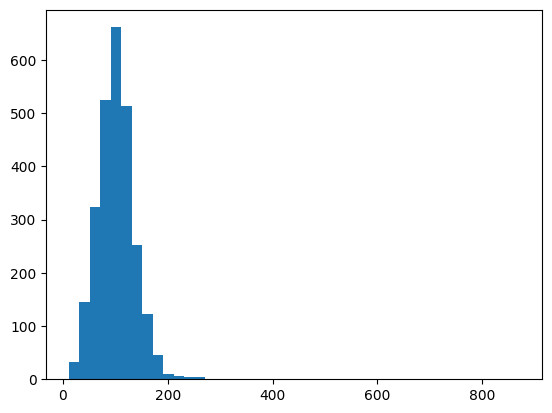

In [17]:
import matplotlib.pyplot as plt
weights = mst.es['weight']
binwidth = 20
bins = np.arange(min(weights), max(weights) + binwidth, binwidth)
plt.hist(weights, bins=bins)
plt.show()

### QUESTION 10

In [18]:
# !pip install geopy

In [ ]:
from geopy.geocoders import Nominatim

# Function to get street address near a location given its latitude and longitude
def get_street_address(lat, lon):
    geolocator = Nominatim(user_agent="my_geocoder")
    location = geolocator.reverse((lat, lon), exactly_one=True)
    if location:
        return location.address
    return None

num_edges_to_report = 5

# Convert EdgeView to list and slice
edges_to_report = list(mst.vs)[:num_edges_to_report]

for i, e in enumerate(mst.es):
    source_centroid = mst.vs[e.source]['coordinates']
    target_centroid =  mst.vs[e.target]['coordinates']
    source_address = get_street_address(source_centroid[1], source_centroid[0])
    target_address = get_street_address(target_centroid[1], target_centroid[0])
    
    print("Edge: ", e.source, e.target)
    print("Source Address:", source_address)
    print("Target Address:", target_address)
    print('Distance in miles: {:.3f}\nTime taken: {:.1f}\n---------\n'.format(linalg.norm(mst.vs[e.source]['coordinates'] - mst.vs[e.target]['coordinates'])* 69, e['weight']))
    print()
    if i > 10:
        break

# TSP Approximation

### QUESTION 11: Check Traingle Inequality

In [20]:
def is_triangle(sides):
    sides.sort()
    return sides[0] + sides[1] > sides[2]

print('Test:', is_triangle([1,4,2]), is_triangle([3,5,3]))

Test: False True


In [21]:
def sample_triangles(g, n_samples):
    result = []
    all_vertices = list(g.vs)
    num_vertices = len(all_vertices)
    
    i = 0
    while i < n_samples:
        triangle_vs = random.sample(all_vertices, 3)
        triangle_ids = [v.index for v in triangle_vs]
        s = 0
        for k in range(3):
            for j in range(k):
                edge = g.get_eid(triangle_ids[k], triangle_ids[j], directed=False, error=False)
                if edge != -1:
                    s += 1
        if s == 3:
            result.append(tuple(triangle_ids))
            i += 1

    return result

In [22]:
n_samples = 1000  # WARNING: this might take a minute for larger sample sizes
triangles = 0
sets_that_have_3_edges = 0
sampled = sample_triangles(g, n_samples)
for triangle_vs in sampled:
    
    edge_lengths = []
    
    for i in range(3):
        for j in range(i):
            edge_lengths.append(min(g.es.select(_between=([triangle_vs[i]], [triangle_vs[j]]))['weight']))   
            
    triangles += is_triangle(edge_lengths)
    
print('Triangle inequality holds by {}%.'.format(round(100.0 * triangles / n_samples, 1)))

Triangle inequality holds by 92.0%.


### QUESTION 12

### Preorder Traversal Demo

In [88]:
def preorder_traversal(root, root_parent=None):
    result = [root]

    neighbors = root.neighbors()
    if root_parent is not None:
        neighbors.remove(root_parent)

    for neighbor in neighbors:
        result.extend(preorder_traversal(neighbor, root))
    return result

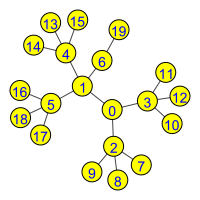

In [89]:
t = Graph.Tree(20, 3)

visual_style = {}
visual_style["vertex_color"] = 'yellow'
visual_style["vertex_label"] = [v.index for v in t.vs]
visual_style["vertex_label_color"] = 'blue'
visual_style["bbox"] = (200, 200)

plot(t, **visual_style)

In [90]:
print([v.index for v in preorder_traversal(t.vs[0])])

[0, 1, 4, 13, 14, 15, 5, 16, 17, 18, 6, 19, 2, 7, 8, 9, 3, 10, 11, 12]


### Actual Data

In [93]:
def find_eulerian_tour(graph):
    tour = []
    stack = [0]  # Start from vertex 0 (or any arbitrary vertex)
    
    while stack:
        v = stack[-1]
        
        if graph.degree(v) == 0:
            tour.append(v)
            stack.pop()
        else:
            u = graph.neighbors(v)[0]  # Take the first neighbor of v
            stack.append(u)
            graph.delete_edges([(v, u)])
    
    return tour[::-1]  # Reverse the tour to get the correct order

In [ ]:
# Create a new graph
vertex_ids = {v: i for i, v in enumerate(mst.vs)}
multigraph = Graph()
multigraph.add_vertices(len(vertex_ids))

for edge in mst.es:
    source = edge.source
    target = edge.target
    multigraph.add_edges([(source, target), (target, source)])

euler_tour = find_eulerian_tour(multigraph)

tour_sequence = []
visited = set()
for node in euler_tour:
    if node not in visited:
        tour_sequence.append(node)
        visited.add(node)

tsp = tour_sequence[:-1]  # Remove the duplicate final node
print('IDs:\n' + '-' * 10 + '\n' + '\n'.join([mst.vs[i]['display_name'] for i in tsp]))

### Measureing Relative Performance Guarantee

In [ ]:
mst_cost = sum(mst.es['weight'])    
hop_distances = []
for i in range(len(tsp) - 1):
    edge_index = g.get_eid(tsp[i], tsp[i + 1], directed=False, error=False)
    hop_distances.append(g.es[edge_index]['weight'])

print('Hop distances:\n' + '-' * 10 + '\n' +
      '\n'.join(['{:.3f}'.format(x) for x in hop_distances]))

In [99]:
tsp_cost = sum(hop_distances)
print('MST Cost:', round(mst_cost))
print('TSP Cost:', round(tsp_cost))
print('Ratio:', round(tsp_cost/mst_cost, 2))

MST Cost: 269085
TSP Cost: 438291
Ratio: 1.63


### QUESTION 13

In [100]:
all_coordinates = np.array(g.vs['coordinates'])
tsp_coordinates = all_coordinates[tsp, :]
tsp_coordinates = np.vstack([tsp_coordinates, tsp_coordinates[0, :]])  # connect the last element back to the first element

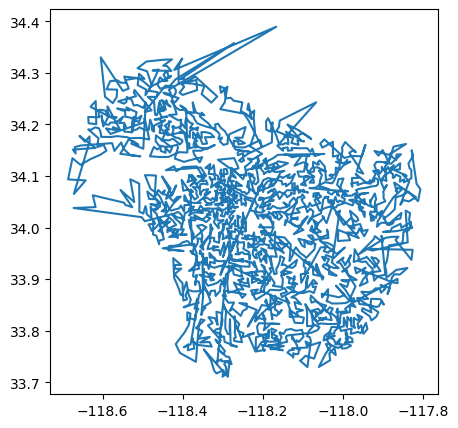

In [101]:
plt.figure(figsize=(5,5))
plt.plot(tsp_coordinates[:, 0], tsp_coordinates[:, 1],'-')
plt.show()

### Triangulation

In [ ]:
tri = #use the Delaunay function imported above 

In [ ]:
plt.figure(figsize=(15,15))
plt.triplot(coordinates[:, 0], coordinates[:, 1], tri.simplices.copy())
plt.show()

In [ ]:
edges_to_induce = []

for i in range(tri.simplices.shape[0]):
    for col1, col2 in ((0, 1), (1, 2), (0, 2)):
        #add the edges to edges_to_induce


In [ ]:
tri_g = g.subgraph_edges(edges_to_induce)

### Estimate Traffic Flows

In [ ]:
edge_ends = #write here 
sources, targets = #write here 
distances = #write here 
speeds =  # write here   # mph
car_length = 0.003  # (miles)
safety_distances = speeds * (2/3600)  # in miles, derived from 2 sec distance
cars_per_mile = #write here
n_lanes = 2
cars_per_hour = #write here 


In [ ]:
tri_g.es['capacity'] = cars_per_hour

# Max Flow Analysis

In [72]:
source_coordinates = [-118.5670548, 34.0458901]  # malibu
dest_coordinates = [-118.1819374, 33.759958]  # long beach

### Calculate Max Flow

In [73]:
print('Number of independent roads:', ) #max flow of graph (inbuilt is okay )
print('Number of cars per hour:', )

Number of independent roads:
Number of cars per hour:


### Trimming Large-Distance (Non-Local) Roads

In [74]:
trim_thresh = 800

In [ ]:
edges_to_induce = tri_g.es.select(weight_le=trim_thresh)
tri_g_trimmed = tri_g.subgraph_edges(edges_to_induce)

### Visualizing Trimming Scheme

<hr><b><font color="red">WARNING: SLOW!</font></b>

In [ ]:
# plot the roads
plt.figure(figsize=(15,15), dpi=200)
for e in tri_g.es:
    v1 = tri_g.vs[e.source]['coordinates']
    v2 = tri_g.vs[e.target]['coordinates']
    data = np.vstack([v1, v2])
    x = data[:, 0]
    y = data[:, 1]
    plt.plot(x, y, '#8ab4f7' if e['weight'] < trim_thresh else '#fc9c3c')
    
# mark the source and destination
# source = tri_g.vs.select(display_name=source_address)[0].index
# target = tri_g.vs.select(display_name=dest_address)[0].index
# v1 = tri_g.vs[source_idx]['coordinates']
# v2 = tri_g.vs[dest_idx]['coordinates']
# data = np.vstack([v1, v2])
# x = data[:, 0]
# y = data[:, 1]
# plt.plot(x, y, 'bo')


plt.axis('equal')
plt.show()

In [77]:
print('Number of independent roads:', ) #max flow of TRIMMED graph
print('Number of cars per hour:', )

Number of independent roads:
Number of cars per hour:


### Aside: Let's Get A Bit of Intuition about Data

In [ ]:

plt.subplot(211)
binwidth = 5
bins = np.arange(np.min(distances), np.max(distances) + binwidth, binwidth)
plt.hist(distances, bins=bins)
plt.xlabel('Distance (miles)')
plt.ylabel('Frequency')
plt.title('Histogram of Distances')
plt.show()

plt.subplot(212)
binwidth = 5
bins = np.arange(0, 100 + binwidth, binwidth)
plt.hist(speeds, bins=bins)#distances, bins=bins)
plt.xlabel('Speed (mph)')
plt.ylabel('Frequency')
plt.title('Histogram of Speeds')
plt.show()

<b>ROAD NETWORK</b>

In [ ]:
road_map = deepcopy(tri_g_trimmed)
len(road_map.vs), len(road_map.es)

Strategy 1 (geodistance_static)

In [ ]:
edge_ends = np.array([[e.source, e.target] for e in road_map.es])
sources, targets = edge_ends[:, 0], edge_ends[:, 1]
distances = #write here 
road_map.es['geo_distance'] = distances
vcount = len(road_map.vs)
max(distances)


In [ ]:
shortest_path_distance = #write here 
shortest_path_distance = np.array(shortest_path_distance)
shortest_path_distance.shape

In [ ]:
actual_geo_distances = np.zeros((vcount,vcount))
actual_geo_distances = None 
differences = None



In [ ]:
ind = #argsort differences to get max value 

In [ ]:
new_static_edges = []
for i in range(40): #40 because there will be repititions (A-> B is same as B-> A)
    if i%2 ==0:
        continue
    newedge = None
    print(#new edge nodes and the difference )
    new_static_edges.append(newedge)

In [ ]:
#add the new_static_edges to our graph. 

road_map_static = deepcopy(tri_g_trimmed) #ensure to use deepcopy
for edg in new_static_edges:
    start = edg[0]
    end = edg[1]
    dist = # which distance to use? 
    road_map_static.add_edge(start, end, weight = dist)

In [ ]:
# plot the roads and highlight our new edges. 
plt.figure(figsize=(15,15), dpi=200)
for e in road_map_static.es:
    start = e.source
    end = e.target
    cur_edge = sorted([start,end])

    v1 = road_map_static.vs[e.source]['coordinates']
    v2 = road_map_static.vs[e.target]['coordinates']
    data = np.vstack([v1, v2])
    x = data[:, 0]
    y = data[:, 1]
    if cur_edge in new_static_edges:
        print(cur_edge)
        plt.plot(x,y,'#FF0000') 
    else:
        plt.plot(x, y, '#8ab4f7')
    
# mark the source and destination
# source = tri_g.vs.select(display_name=source_address)[0].index
# target = tri_g.vs.select(display_name=dest_address)[0].index
# v1 = road_map_static.vs[source_idx]['coordinates']
# v2 = road_map_static.vs[dest_idx]['coordinates']
# data = np.vstack([v1, v2])
# x = data[:, 0]
# y = data[:, 1]
# plt.plot(x, y, 'bo')



plt.axis('equal')
plt.show()

In [ ]:
# A, B >1000, freq:10 ->10,000
#C, D = 500 , 10,000 - > 500*10,000

Strategy 2 (geo_distance, static, with_frequency)

In [ ]:
np.random.seed(2022)
frequencies = np.random.randint(1,1001, (vcount,vcount) )
frequencies.shape

In [ ]:
difference_frequency = np.multiply(differences,frequencies)

In [ ]:
ind = #argsort differences to get max value 

In [ ]:
for i in range(40): #40 because there will be repititions (A-> B is same as B-> A)
    if i%2 ==0:
        continue
    print(#new edge nodes and the difference )


Stategy 3 : (geo_distance, Dynamic)

In [ ]:
road_map_dynamic = deepcopy(road_map)
budget = 20
new_dynamic_edges = []
for i in range(budget):
    
    #get current graph shortest paths 
    #get differences 
    #sort differences and pich the highest         
    # get vertices of new edge to build. Build the edge and print its vertices. 
    new_egde = None
    print(new_Edge, difference_between_new_edge_vertices  )
    new_dynamic_edges.append(new_edge )

    #add the new edge 
    new_distance = #Get this 
    road_map_dynamic.add_edge(start, end, weight = -1 , geo_distance = new_distance)

In [ ]:
# plot the roads
plt.figure(figsize=(15,15), dpi=200)
for e in road_map_dynamic.es:
    start = e.source
    end = e.target
    cur_edge = sorted([start,end])

    v1 = road_map_dynamic.vs[e.source]['coordinates']
    v2 = road_map_dynamic.vs[e.target]['coordinates']
    data = np.vstack([v1, v2])
    x = data[:, 0]
    y = data[:, 1]
    if cur_edge in new_dynamic_edges:
        print(cur_edge)
        plt.plot(x,y,'#FF0000')
    else:
        plt.plot(x, y, '#8ab4f7' )
    
# mark the source and destination
# source = tri_g.vs.select(display_name=source_address)[0].index
# target = tri_g.vs.select(display_name=dest_address)[0].index
# v1 = road_map.vs[source_idx]['coordinates']
# v2 = road_map.vs[dest_idx]['coordinates']
# data = np.vstack([v1, v2])
# x = data[:, 0]
# y = data[:, 1]
# plt.plot(x, y, 'bo')


plt.axis('equal')
plt.show()

strategy 4 : (travel_time, static)

In [ ]:
road_map_time = deepcopy(tri_g_trimmed)

In [ ]:
#get current shortest times
#get current shortest distances 
#speed = shortest_distance/time
time_diffence = current_shortest_time - actual_geo_distance/speed  
#explicitly set time_diffence to 0 for self edges, to avoid divide_by_zero error

time dynamic

In [ ]:
road_map_time_dynamic = deepcopy(tri_g_trimmed)

In [ ]:
budget = 20
new_dynamic_time_edges = []

for i in range(budget):

    

## Question 15
Max Capacity =• Each degree of latitude and longitude ≈ 69 miles
• Car length ≈ 5 m = 0.003 mile
• Cars maintain a safety distance of 2 seconds to the next car
• Each road has 2 lanes in each direction

2v/(.003+v/`1800)


##Question 14/16

In [89]:
import numpy as np
import json
from scipy.spatial import Delaunay
from igraph import Graph

lat_long = {}

with open('los_angeles_censustracts.json', 'r') as f:
    d = json.load(f)
    features = d['features']

    for feature in features:
        latitude = 0.0
        longitude = 0.0

        geometry_type = feature['geometry']['type']
        coordinates = np.array(feature['geometry']['coordinates'][0]) if geometry_type == 'Polygon' else np.array(
            feature['geometry']['coordinates'][0][0])

        for coordinate in coordinates:
            latitude += coordinate[1]
            longitude += coordinate[0]

        latitude /= len(coordinates)
        longitude /= len(coordinates)

        movement_id = feature['properties']['MOVEMENT_ID']
        display_name = feature['properties']['DISPLAY_NAME']

        lat_long[movement_id] = (display_name, latitude, longitude)

lat = []
lon = []
for i in range(1, len(lat_long) + 1):
    lat.append(lat_long[str(i)][1])
    lon.append(lat_long[str(i)][2])

lat_lon = tuple(zip(lat, lon))
delaunay_out = Delaunay(lat_lon)

edges = delaunay_out.simplices
g_del = Graph.TupleList(edges, directed=False, vertex_name_attr='name')

f.close()


Max Capacity =• Each degree of latitude and longitude ≈ 69 miles
• Car length ≈ 5 m = 0.003 mile
• Cars maintain a safety distance of 2 seconds to the next car
• Each road has 2 lanes in each direction

2v/(.003+v/`1800)


In [90]:
malibu= [34.026, -118.78]
long_beach =  [33.77, -118.18]
velocity=(69*np.sqrt((malibu[0]-long_beach[0])**2+(malibu[1]-long_beach[1])**2))
max_cars=2*velocity/(.003+velocity/1800)

min_long_beach=np.inf
min_malibu=np.inf
long_beach_node=0
malibu_node=0
for i in range(1,len(lat_lon)):
    long_beach_closest=np.sqrt(((lat_lon[i][0])-long_beach[0])**2+((lat_lon[i][1])-long_beach[1])**2)
    malibu_closest=np.sqrt((malibu[0]-lat_lon[i][0])**2+(malibu[1]-lat_lon[i][1])**2)
    if long_beach_closest<min_long_beach:
        min_long_beach=long_beach_closest
        long_beach_node=i
    if malibu_closest<min_malibu:
        min_malibu=malibu_closest
        malibu_node=i

deg_dist_mal = g_del.degree(malibu_node,mode='out')
deg_dist_lb = g_del.degree(long_beach_node,mode='in')
paths = g_del.adhesion(long_beach_node,malibu_node)
        




In [91]:
print(max_cars)
print(deg_dist_mal )
print(deg_dist_lb)
print(paths)

3214.3687557752646
4
5
4


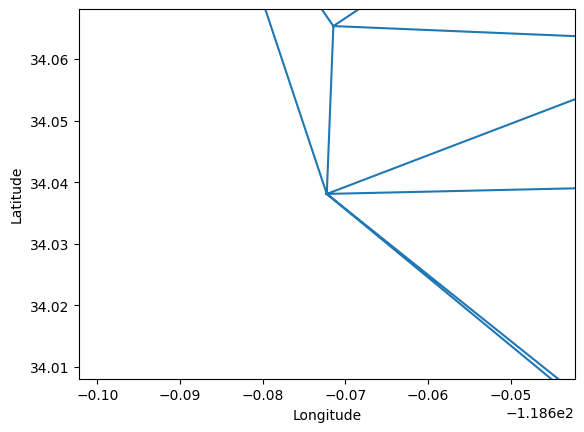

In [92]:
plt.triplot(lon, lat, delaunay_out.simplices)
plt.ylim(lat_lon[malibu_node][0]-0.03,lat_lon[malibu_node][0]+0.03)
plt.xlim(lat_lon[malibu_node][1]-0.03,lat_lon[malibu_node][1]+0.03)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.plot(lon[malibu_node], lat[malibu_node])
plt.show()

## Question 17

In [96]:
g_temp = Graph()
g_temp.add_vertices(len(delaunay_out.points))

# Set vertex attributes for latitude and longitude
g_temp.vs['lat'] = lat
g_temp.vs['lon'] = lon

coordinate_threshold = 19.2 / 69  # Distance threshold for edge existence

fake_edges = set()

for simplex in delaunay_out.simplices:
    edges = [(simplex[0], simplex[1]), (simplex[0], simplex[2]), (simplex[1], simplex[2])]
    for edge in edges:
        edge = tuple(sorted(edge))
        v1 = g_temp.vs[edge[0]]
        v2 = g_temp.vs[edge[1]]
        v1_lat, v1_lon = v1['lat'], v1['lon']
        v2_lat, v2_lon = v2['lat'], v2['lon']
        distance = np.sqrt((v1_lat - v2_lat) ** 2 + (v1_lon - v2_lon) ** 2)
        if distance < coordinate_threshold:
            g_temp.add_edge(edge[0], edge[1])
        else:
            fake_edges.add(edge)


#g_temp.delete_edges(fake_edges)


In [97]:
thresh_plot = [] 
for simplex in delaunay_out.simplices:
    found_edge = False
    for edge in fake_edges:
        vertex1, vertex2 = edge
        if vertex1 in simplex and vertex2 in simplex:
            found_edge = True
            break
    
    if not found_edge:
        thresh_plot.append(simplex)

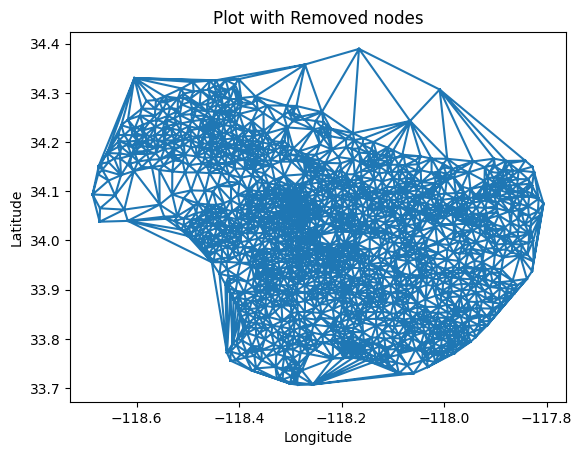

In [98]:

plt.triplot(lon, lat, thresh_plot)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Plot with Removed nodes')
plt.show()

In [99]:
for ind in fake_edges:
  g_temp.delete_edges(ind)

In [100]:
type(thresh_plot)

list

## Q 18 relies on 13

In [34]:
# malibu= [34.026, -118.78]
# long_beach =  [33.77, -118.18]
# velocity=(69*np.sqrt((malibu[0]-long_beach[0])**2+(malibu[1]-long_beach[1])**2))
# max_cars=2*velocity/(.003+velocity/1800)

# min_long_beach=np.inf
# min_malibu=np.inf
# long_beach_node=0
# malibu_node=0
# for i in range(1,len(lat_lon)):
#     long_beach_closest=np.sqrt(((lat_lon[i][0])-long_beach[0])**2+((lat_lon[i][1])-long_beach[1])**2)
#     malibu_closest=np.sqrt((malibu[0]-lat_lon[i][0])**2+(malibu[1]-lat_lon[i][1])**2)
#     if long_beach_closest<min_long_beach:
#         min_long_beach=long_beach_closest
#         long_beach_node=i
#     if malibu_closest<min_malibu:
#         min_malibu=malibu_closest
#         malibu_node=i

# deg_dist_mal = g_del.degree(malibu_node,mode='out')
# deg_dist_lb = g_del.degree(long_beach_node,mode='in')
# paths = g_del.adhesion(long_beach_node,malibu_node)
        




In [101]:
print(g_temp.adhesion(long_beach_node,malibu_node)-1)
print(g_temp.degree(malibu_node,mode='out')-1)
print(g_temp.degree(long_beach_node,mode='in')-1)

6
6
11


In [102]:

malibu= [34.026, -118.78]
long_beach =  [33.77, -118.18]
velocity=(69*np.sqrt((malibu[0]-long_beach[0])**2+(malibu[1]-long_beach[1])**2))
max_cars=2*velocity/(.003+velocity/1800)

min_long_beach=np.inf
min_malibu=np.inf
long_beach_node=0
malibu_node=0
for i in range(1,len(lat_lon)):
    long_beach_closest=np.sqrt(((lat_lon[i][0])-long_beach[0])**2+((lat_lon[i][1])-long_beach[1])**2)
    malibu_closest=np.sqrt((malibu[0]-lat_lon[i][0])**2+(malibu[1]-lat_lon[i][1])**2)
    if long_beach_closest<min_long_beach:
        min_long_beach=long_beach_closest
        long_beach_node=i
    if malibu_closest<min_malibu:
        min_malibu=malibu_closest
        malibu_node=i

deg_dist_mal = g_del.degree(malibu_node,mode='out')
deg_dist_lb = g_del.degree(long_beach_node,mode='in')
paths = g_del.adhesion(long_beach_node,malibu_node)
        




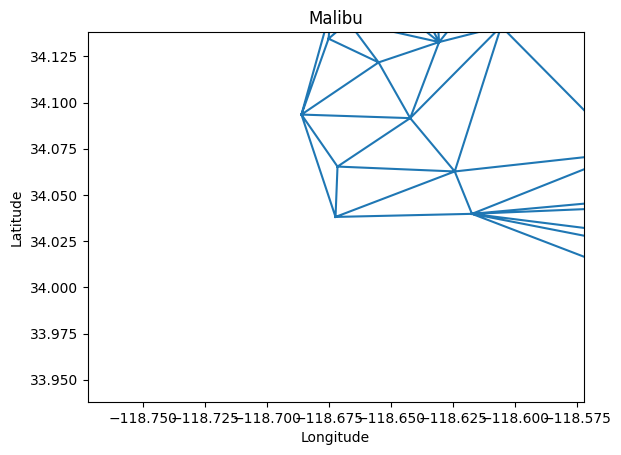

In [103]:
plt.triplot(lon, lat, thresh_plot)
plt.ylim(lat_lon[malibu_node][0]-0.1,lat_lon[malibu_node][0]+0.1)
plt.xlim(lat_lon[malibu_node][1]-0.1,lat_lon[malibu_node][1]+0.1)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Malibu')
plt.plot(lon[malibu_node], lat[malibu_node])

## Q 19

In [ ]:
import numpy as np
import igraph as ig
from itertools import combinations
from operator import itemgetter

def calculate_euclidean_distance(v1, v2):
    return np.sqrt((v1['lat'] - v2['lat']) ** 2 + (v1['lon'] - v2['lon']) ** 2)

def calculate_extra_distance(v1, v2):
    shortest_distance = g_temp.shortest_paths_dijkstra(source=v1.index, target=v2.index, weights='weight')[0][0]
    euclidean_distance = calculate_euclidean_distance(v1, v2)
    extra_distance = shortest_distance - euclidean_distance
    return extra_distance

g_temp = ig.Graph()
g_temp.add_vertices(len(delaunay_out.points))

g_temp.vs['lat'] = lat
g_temp.vs['lon'] = lon

# Add edges to the graph based on coordinate threshold
coordinate_threshold = 19.2 / 69  # Distance threshold for edge existence
for simplex in delaunay_out.simplices:
    edges = [(simplex[0], simplex[1]), (simplex[0], simplex[2]), (simplex[1], simplex[2])]
    for edge in edges:
        edge = tuple(sorted(edge))
        v1 = g_temp.vs[edge[0]]
        v2 = g_temp.vs[edge[1]]
        v1_lat, v1_lon = v1['lat'], v1['lon']
        v2_lat, v2_lon = v2['lat'], v2['lon']
        distance = np.sqrt((v1_lat - v2_lat) ** 2 + (v1_lon - v2_lon) ** 2)
        if distance < coordinate_threshold:
            g_temp.add_edge(edge[0], edge[1], weight=distance)

# Calculate extra distance between all pairs of points
extra_distances = []
vertices = g_temp.vs()
for v1, v2 in combinations(vertices, 2):
    extra_distance = calculate_extra_distance(v1, v2)
    extra_distances.append((v1.index, v2.index, extra_distance))

# Sort the extra distances in descending order
extra_distances.sort(key=itemgetter(2), reverse=True)

# Get the top 20 pairs with highest extra distance
top_pairs = extra_distances[:20]

# Print the source and destination of the top pairs
for pair in top_pairs:
    source = vertices[pair[0]]
    destination = vertices[pair[1]]
    print(f"Source: ({source['lat']}, {source['lon']}), Destination: ({destination['lat']}, {destination['lon']})")

# Create new edges in the graph for the top pairs
for pair in top_pairs:
    source_index = pair[0]
    destination_index = pair[1]
    g_temp.add_edge(source_index, destination_index)

# Plot the resultant graph on actual coordinates
layout = g_temp.layout_auto()
visual_style = dict(layout=layout, vertex_size=10)
ig.plot(g_temp, **visual_style)


In [ ]:
ig.plot(g_temp, **visual_style)
